In [21]:
from typing import Tuple
import  os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

import torch
import torch.nn.functional as F
from torch.nn import RMSNorm
from rich import print

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

In [3]:
model = model.eval()
tokens = tokenizer("Hello, how are you?", return_tensors="pt")
out_tokens = model(**tokens)
# print(out_tokens)
print(out_tokens.logits.shape) 

torch.Size([1, 7, 128256])

In [12]:
from dataclasses import dataclass
from typing import Optional
from torch import nn

@dataclass
class ModelArgs:
    device: str = "cpu"
    dim=2048
    n_layers=16  # Match HF's num_hidden_layers
    n_heads=32
    n_kv_heads=8  # GQA confirmed
    vocab_size=128256
    multiple_of=256
    ffn_dim_multiplier=None  # Adjust MLP manually
    norm_eps=1e-5
    rope_theta=500000.0
    max_batch_size=4
    max_seq_len=2048

<!-- 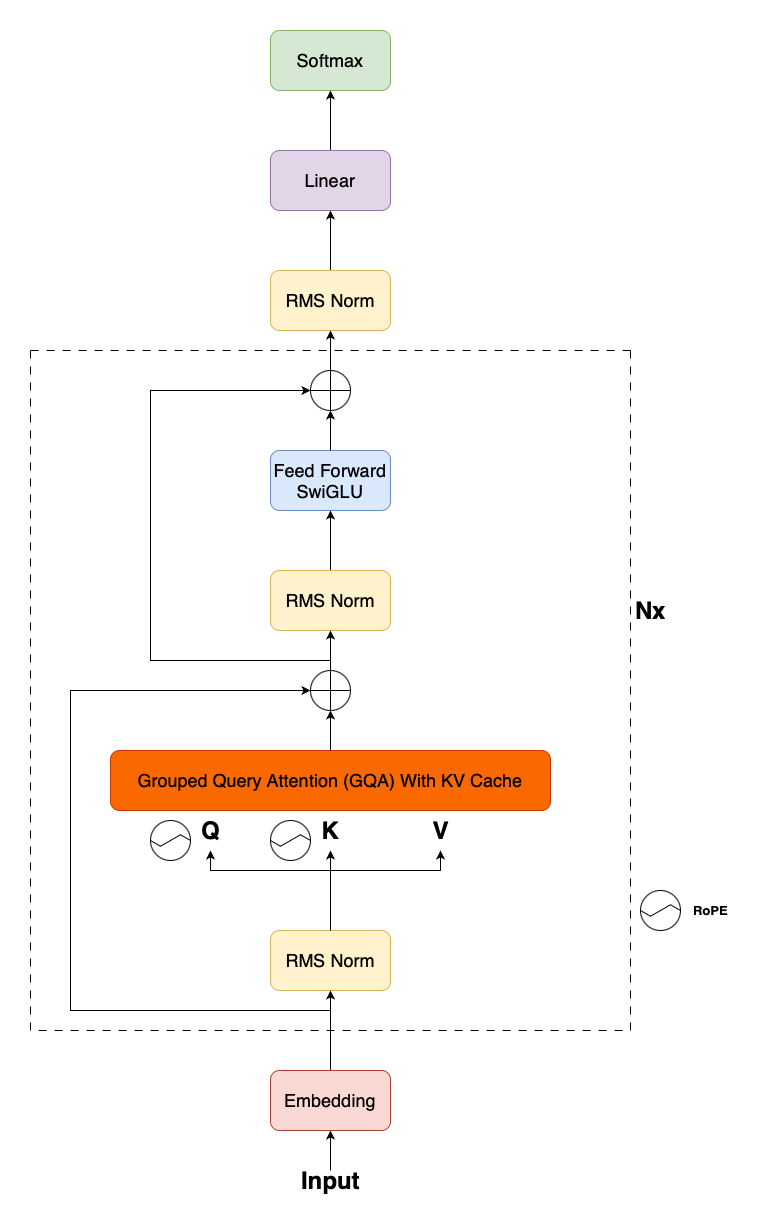 -->

In [6]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f"shape mismatch {freqs_cis.shape}, {(x.shape[1], x.shape[-1])}"
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor]:
    # TODO: FOLLOW UP
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [7]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, multiple_of, ffn_dim_multiplier=None):
        super().__init__()
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.gate_proj = nn.Linear(dim, hidden_dim, bias=False)
        self.up_proj = nn.Linear(dim, hidden_dim, bias=False)
        self.down_proj = nn.Linear(hidden_dim, dim, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

In [10]:
class Attention(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.head_dim = params.dim // params.n_heads
        self.n_reps = params.n_heads // params.n_kv_heads
        self.n_kv_heads = params.n_kv_heads
        self.n_heads = params.n_heads
        self.dim = params.dim
        self.device = params.device
        self.max_seq_len = params.max_seq_len
        self.max_batch_size = params.max_batch_size

        self.q_proj = nn.Linear(params.dim, params.n_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(params.dim, params.n_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(params.dim, params.n_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(params.n_heads * self.head_dim, params.dim, bias=False)  # Fixed output dim

        self.k_cache = None
        self.v_cache = None

    def forward(self, x, start_pos, freqs_cis, mask):
        bsz, seq_len, _ = x.shape

        # Initialize or reset cache if needed
        if self.k_cache is None or self.k_cache.shape[0] != bsz or self.k_cache.device != x.device:
            self.k_cache = torch.zeros(bsz, self.max_seq_len, self.n_kv_heads, self.head_dim, device=x.device)
            self.v_cache = torch.zeros(bsz, self.max_seq_len, self.n_kv_heads, self.head_dim, device=x.device)

        # Projections and reshaping
        xq = self.q_proj(x).view(bsz, seq_len, self.n_heads, self.head_dim)
        xk = self.k_proj(x).view(bsz, seq_len, self.n_kv_heads, self.head_dim)
        xv = self.v_proj(x).view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        # Update cache
        self.k_cache[:bsz, start_pos:start_pos + seq_len] = xk
        self.v_cache[:bsz, start_pos:start_pos + seq_len] = xv

        # Retrieve full keys and values
        xk = self.k_cache[:bsz, :start_pos + seq_len]
        xv = self.v_cache[:bsz, :start_pos + seq_len]

        # Repeat KV for GQA
        xk = torch.repeat_interleave(xk, dim=2, repeats=self.n_reps)
        xv = torch.repeat_interleave(xv, dim=2, repeats=self.n_reps)

        # Attention computation
        xq = xq.transpose(1, 2)  # (bsz, n_heads, seq_len, head_dim)
        xk = xk.transpose(1, 2)  # (bsz, n_heads, seq_len + start_pos, head_dim)
        xv = xv.transpose(1, 2)  # (bsz, n_heads, seq_len + start_pos, head_dim)

        scores = torch.matmul(xq, xk.transpose(2, 3)) / (
                self.head_dim ** 0.5)  # (bsz, n_heads, seq_len, seq_len + start_pos)
        if mask is not None:
            scores = scores + mask  # Broadcasting needs mask shape (seq_len, start_pos + seq_len)

        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, xv)  # (bsz, n_heads, seq_len, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seq_len, -1)  # (bsz, seq_len, dim)
        return self.o_proj(output)


In [15]:
params = ModelArgs()
attn = Attention(params)

start_pos = 0
seqlen = 10
x = torch.randn(1, seqlen, params.dim)
_freq_cis = precompute_freqs_cis(
                params.dim // params.n_heads,
                params.max_seq_len * 2,
                params.rope_theta,
            )
_freq_cis = _freq_cis[start_pos : start_pos + seqlen]
attn(x, start_pos, _freq_cis, None)

tensor([[[-1.0456e-01, -5.1665e-02,  1.2901e-01,  ..., -4.6654e-05,
          -7.9516e-02,  8.0068e-02],
         [-8.2464e-02, -5.5121e-02,  1.5113e-01,  ..., -5.4955e-02,
          -1.0621e-01,  1.1096e-01],
         [-1.4238e-01, -9.4260e-02,  1.6770e-01,  ..., -9.6464e-02,
          -1.2324e-01,  1.5336e-01],
         ...,
         [-1.6298e-02, -6.0807e-02,  1.3979e-01,  ..., -1.7749e-02,
          -1.8597e-01,  1.1950e-01],
         [-3.3805e-02, -1.0758e-01,  1.6935e-01,  ..., -1.0473e-01,
          -8.3386e-02,  1.7840e-02],
         [-2.6519e-02, -5.2319e-02,  2.5280e-01,  ..., -1.0117e-01,
          -7.4089e-02,  1.0459e-01]]], grad_fn=<UnsafeViewBackward0>)

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.self_attn = Attention(params)
        self.mlp = MLP(params.dim, 4 * params.dim, params.multiple_of, params.ffn_dim_multiplier)
        self.input_layernorm = nn.RMSNorm(params.dim, eps=params.norm_eps)
        self.post_attention_layernorm = RMSNorm(params.dim, eps=params.norm_eps)

    def forward(self, x, start_pos, freq_cis, mask):
        h = x + self.self_attn(self.input_layernorm(x), start_pos, freq_cis, mask)
        out = h + self.mlp(self.post_attention_layernorm(h))
        return out

In [17]:
class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.embed_tokens = nn.Embedding(params.vocab_size, params.dim)
        self.layers = nn.ModuleList([TransformerBlock(params) for _ in range(params.n_layers)])
        self.norm = nn.RMSNorm(params.dim, eps=params.norm_eps)
        self.lm_head = nn.Linear(params.dim, params.vocab_size, bias=False)

        self.freqs_cis = precompute_freqs_cis(
            params.dim // params.n_heads,
            params.max_seq_len * 2,
            params.rope_theta,
        )

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int=0):
        _bsz, seqlen = tokens.shape
        h = self.embed_tokens(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack(
                [torch.zeros((seqlen, start_pos), device=tokens.device), mask]
            ).type_as(h)

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.lm_head(h).float()
        return output

In [22]:
params = ModelArgs()
with torch.device(params.device):
    llama = Transformer(params)
    print(llama)

Transformer(
  (embed_tokens): Embedding(128256, 2048)
  (layers): ModuleList(
    (0-15): 16 x TransformerBlock(
      (self_attn): Attention(
        (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2048, out_features=512, bias=False)
        (v_proj): Linear(in_features=2048, out_features=512, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      )
      (mlp): MLP(
        (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
        (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
        (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): RMSNorm((2048,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): RMSNorm((2048,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): RMSNorm((2048,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
)

In [24]:
def map_state_dict(hf_state_dict, custom_model):
    custom_state_dict = custom_model.state_dict()
    mapped_state_dict = {}

    mapped_state_dict['embed_tokens.weight'] = hf_state_dict['model.embed_tokens.weight']
    for i in range(custom_model.params.n_layers):
        prefix = f'layers.{i}'
        hf_prefix = f'model.layers.{i}'
        mapped_state_dict[f'{prefix}.self_attn.q_proj.weight'] = hf_state_dict[f'{hf_prefix}.self_attn.q_proj.weight']
        mapped_state_dict[f'{prefix}.self_attn.k_proj.weight'] = hf_state_dict[f'{hf_prefix}.self_attn.k_proj.weight']
        mapped_state_dict[f'{prefix}.self_attn.v_proj.weight'] = hf_state_dict[f'{hf_prefix}.self_attn.v_proj.weight']
        mapped_state_dict[f'{prefix}.self_attn.o_proj.weight'] = hf_state_dict[f'{hf_prefix}.self_attn.o_proj.weight']
        mapped_state_dict[f'{prefix}.mlp.gate_proj.weight'] = hf_state_dict[f'{hf_prefix}.mlp.gate_proj.weight']
        mapped_state_dict[f'{prefix}.mlp.up_proj.weight'] = hf_state_dict[f'{hf_prefix}.mlp.up_proj.weight']
        mapped_state_dict[f'{prefix}.mlp.down_proj.weight'] = hf_state_dict[f'{hf_prefix}.mlp.down_proj.weight']
        mapped_state_dict[f'{prefix}.input_layernorm.weight'] = hf_state_dict[f'{hf_prefix}.input_layernorm.weight']
        mapped_state_dict[f'{prefix}.post_attention_layernorm.weight'] = hf_state_dict[
            f'{hf_prefix}.post_attention_layernorm.weight']
    mapped_state_dict['norm.weight'] = hf_state_dict['model.norm.weight']
    mapped_state_dict['lm_head.weight'] = hf_state_dict['lm_head.weight']

    custom_state_dict.update(mapped_state_dict)
    custom_model.load_state_dict(custom_state_dict, strict=False)
    return custom_model


def generate(model, tokenizer, prompt, max_length=50, device="cuda"):
    model.eval()
    with torch.no_grad():
        prompt_tokens = tokenizer.encode(prompt)
        sequence = prompt_tokens.copy()
        tokens = torch.tensor([prompt_tokens], dtype=torch.long, device=device)

        logits = model(tokens, start_pos=0)
        next_token_id = torch.argmax(logits[:, -1, :], dim=-1).item()
        sequence.append(next_token_id)

        start_pos = len(prompt_tokens)
        while len(sequence) < max_length:
            next_input = torch.tensor([[next_token_id]], dtype=torch.long, device=device)
            logits = model(next_input, start_pos)
            next_token_id = torch.argmax(logits[:, 0, :], dim=-1).item()
            sequence.append(next_token_id)
            start_pos += 1
            if next_token_id == tokenizer.eos_token_id:
                break

        return tokenizer.decode(sequence)

In [32]:
# Initialize custom model
llama = Transformer(params).to(params.device)

# Load HF model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

# Map and load weights
llama = map_state_dict(hf_model.state_dict(), llama)
llama.to(params.device)  # Ensure model is on the correct device

# Generate text
generated_text = generate(llama, tokenizer, "To break eggs properly, you need to", max_length=100, device=params.device)
print(generated_text)

<|begin_of_text|>To break eggs properly, you need to have a good egg white, and a good egg white, and a good egg 
white, and a good egg white, and a good egg white, and a good egg white, and a good egg white, and a good egg 
white, and a egg white, and a egg white, and a egg white, and a egg white, and a egg white, and a egg white, and a 
egg white, and a egg white, and a egg